## Anova and Correlation

### Imports

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


### Read Data

In [ ]:
DATA_DIR = '../../data/processed/'
TRAIN_FILE = f'{DATA_DIR}/train.parquet'
TEST_FILE = f'{DATA_DIR}/test.parquet'
VALIDATION_FILE = f'{DATA_DIR}/validation.parquet'

train_df = pd.read_parquet(TRAIN_FILE)
test_df = pd.read_parquet(TEST_FILE)
validation_df = pd.read_parquet(VALIDATION_FILE)

### Define target and drop appid

In [ ]:
target_col = 'copiesSold'
train_df = train_df.drop(columns=['appid'])
test_df = test_df.drop(columns=['appid'])
validation_df = validation_df.drop(columns=['appid'])

### Separate features

In [ ]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
X_val = validation_df.drop(columns=[target_col])
y_val = validation_df[target_col]

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

### Drop Highly Correlated Features

In [ ]:
corr_threshold = 0.9
corr_matrix = train_df[numerical_cols + [target_col]].corr().abs()

to_drop = [] # contains pairs of features (dropped, highly correlated with dropped)
to_drop_features = [] # contains features to drop

# iterate over the upper triangle to avoid duplicates and compare each pair only once
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        
        if corr_matrix.iloc[i, j] > corr_threshold:

            col1_corr_with_target = corr_matrix[target_col][col1]
            col2_corr_with_target = corr_matrix[target_col][col2]
            
            # drop the one with the least correlation with the target
            if col1_corr_with_target < col2_corr_with_target:
                to_drop.append((col1, col2))
            else:
                to_drop.append((col2, col1))

# drop the highly correlated features
for item in to_drop:
    to_drop_features.append(item[0])
train_df.drop(columns=to_drop_features, inplace=True)
test_df.drop(columns=to_drop_features, inplace=True)
validation_df.drop(columns=to_drop_features, inplace=True)

print(f"Dropped {len(to_drop_features)} highly correlated features: {to_drop_features}")
print(f"Pairs of features (dropped, highly correlated with dropped): {to_drop}")


Dropped 3 highly correlated features: ['name_len', 'demo_count', 'dlc_count']
Pairs of features (dropped, highly correlated with dropped): [('name_len', 'name_words'), ('demo_count', 'has_demo'), ('dlc_count', 'has_dlc')]


### Re-assign variables after dropping

In [ ]:
X_train = train_df.drop(columns=[target_col])
X_test = test_df.drop(columns=[target_col])
X_val = validation_df.drop(columns=[target_col])
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

### Correlation with Numerical Features

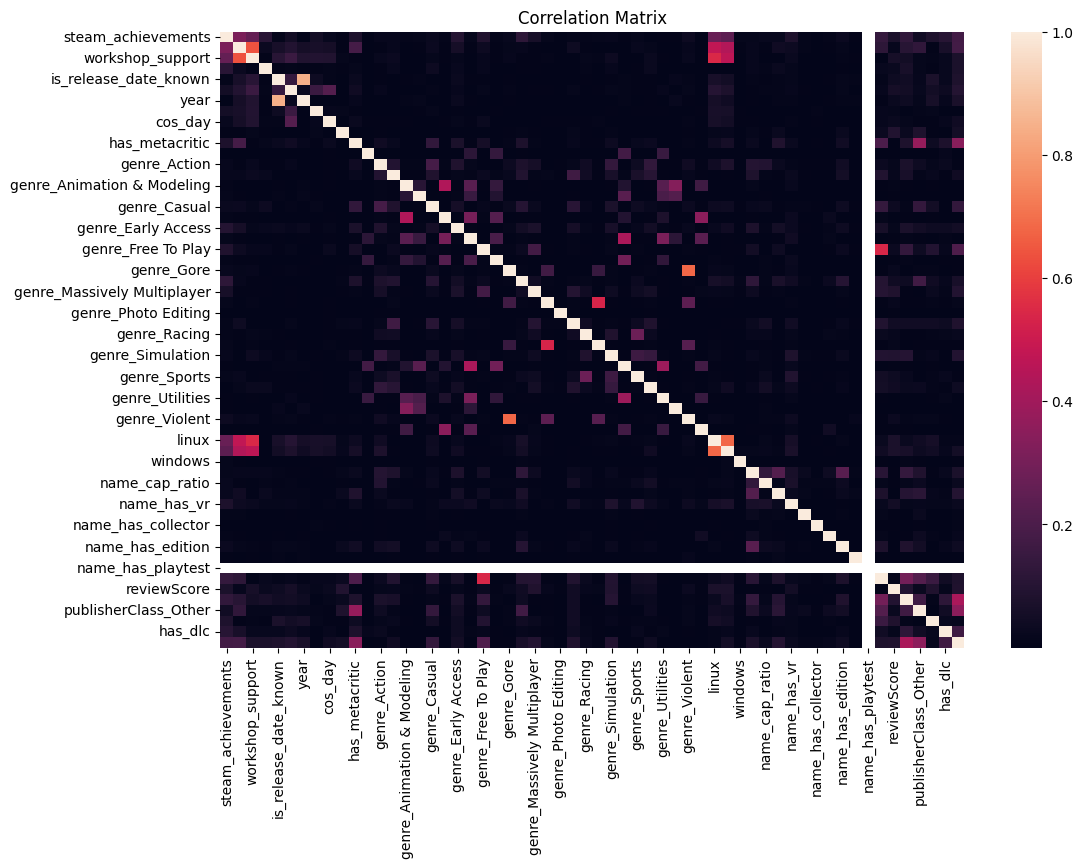

,feature,correlation
0,publisherClass_Indie,0.420674
1,publisherClass_Other,0.353768
2,has_metacritic,0.345550
3,genre_Free To Play,0.206684
4,steam_trading_cards,0.179513
5,steam_achievements,0.175463
6,has_dlc,0.167505
7,genre_Casual,0.133536
8,is_sequel,0.097095
9,is_upcoming,0.094189


In [ ]:
reduced_corr_matrix = train_df[numerical_cols + [target_col]].corr().abs()
correlations = reduced_corr_matrix[target_col].drop(target_col).sort_values(ascending=False)

# visualize Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(reduced_corr_matrix)
plt.title('Correlation Matrix')
plt.show()

corr = pd.DataFrame(correlations).reset_index()
corr.columns = ['feature', 'correlation']

corr

### ANOVA for Categorical Features

In [ ]:
anova_results = []
for col in categorical_cols:
    if 1 < train_df[col].nunique() <= 2500: 
        model = ols(f'{target_col} ~ C({col})', data=train_df[[col, target_col]]).fit()
        p_value = sm.stats.anova_lm(model, typ=2).iloc[0]['PR(>F)']
        anova_results.append((col, p_value))

anova_df = pd.DataFrame(anova_results, columns=["Feature", "P-Value"]).sort_values("P-Value")

anova_df

,Feature,P-Value
0,genres,0.000000e+00
1,supported_platforms,6.974636e-125


- What happened here is that there are only 2 categorical features with unique values less than or equal to 2500
- Both of their p-values are very small, which means they significantly affect the outcome of the model.
- This means that these two categorical features have a strong relationship with the target variable.

### Select Top 50 Features

In [9]:
top_numeric = correlations.head(48).index.tolist()
top_categorical = anova_df.head(2)["Feature"].tolist() # only two categorical feature
selected_features = top_numeric + top_categorical
selected_features

['publisherClass_Indie',
 'publisherClass_Other',
 'has_metacritic',
 'genre_Free To Play',
 'steam_trading_cards',
 'steam_achievements',
 'has_dlc',
 'genre_Casual',
 'is_sequel',
 'is_upcoming',
 'genre_Simulation',
 'genre_Massively Multiplayer',
 'genre_RPG',
 'reviewScore',
 'is_release_date_known',
 'price',
 'achievements_total',
 'name_words',
 'workshop_support',
 'year',
 'genre_Indie',
 'mac',
 'metacritic_preprocessed',
 'genre_Early Access',
 'cos_day',
 'genre_Adventure',
 'name_has_edition',
 'genre_Strategy',
 'name_has_vr',
 'name_cap_ratio',
 'genre_Racing',
 'name_has_collection',
 'has_demo',
 'genre_Nudity',
 'linux',
 'name_has_remaster',
 'name_has_collector',
 'genre_Sexual Content',
 'genre_Sports',
 'genre_Gore',
 'genre_Game Development',
 'genre_Action',
 'windows',
 'genre_Design & Illustration',
 'genre_Audio Production',
 'sin_day',
 'genre_Violent',
 'genre_Software Training',
 'genres',
 'supported_platforms']

### Transformer and Pipeline

In [11]:
results = []

transformer = ColumnTransformer(
    transformers=[ 
        ('num', 'passthrough', []),  
        ('cat', OneHotEncoder(), [])
    ])

pipeline = Pipeline(steps=[ 
    ('preprocessor', transformer),
    ('regressor', XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    ))
])


### Evaluate Feature Combinations with addition of features

In [12]:
for i in range(1, len(selected_features) + 1):
    feature_subset = selected_features[:i]
    
    # update the transformer with the current subset of features
    num_features = [feat for feat in feature_subset if feat in numerical_cols]
    cat_features = [feat for feat in feature_subset if feat in categorical_cols]
    transformer.transformers[0] = ('num', 'passthrough', num_features)
    transformer.transformers[1] = ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)

    pipeline.fit(X_train[feature_subset], y_train)
    y_pred = pipeline.predict(X_test[feature_subset])
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((i, feature_subset, mse, r2))

results_df = pd.DataFrame(results, columns=['Number of Features', 'Features', 'MSE', 'R²'])

results_df_sorted = results_df.sort_values(by=['R²', 'MSE'], ascending=[False, True]) # higher R² and lower MSE are better

print(results_df_sorted[:10]) # show the top 10 results


    Number of Features                                           Features  \
49                  50  [publisherClass_Indie, publisherClass_Other, h...   
48                  49  [publisherClass_Indie, publisherClass_Other, h...   
41                  42  [publisherClass_Indie, publisherClass_Other, h...   
36                  37  [publisherClass_Indie, publisherClass_Other, h...   
34                  35  [publisherClass_Indie, publisherClass_Other, h...   
35                  36  [publisherClass_Indie, publisherClass_Other, h...   
37                  38  [publisherClass_Indie, publisherClass_Other, h...   
32                  33  [publisherClass_Indie, publisherClass_Other, h...   
42                  43  [publisherClass_Indie, publisherClass_Other, h...   
43                  44  [publisherClass_Indie, publisherClass_Other, h...   

         MSE        R²  
49  0.297790  0.711210  
48  0.297907  0.711096  
41  0.298270  0.710744  
36  0.298345  0.710671  
34  0.298352  0.710664  
35